# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler



## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
## Jupyter notebook had to be updated to accomodate my implemented functionalities

#!pip install -U jupyter

In [3]:
# Define transforms

transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)])


# Create training set and define training dataloader

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                            transform=transforms)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                            transform=transforms)

# obtain training indices that will be used for validation - using default method, SubsetRandomSampler since
# Dataset is not Costum
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 20

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

classes = [i for i in range(10)]

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have worked on similar projects as this on multiple iterations, although a relatively low complexity of the task, I opted for a 3-way datasplit including a standard validation compartment. I have only used basic transforms and ommitted augmentations although augmentations on the trainingset could be experimented with, also there are numerous discussion on stackoverflow, [1](https://stackoverflow.com/questions/53808335/data-augmentation-in-validation), [2](https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set), which suggest potential benefits on additionally augmenting **validation data**. Conventionally, to have a realistic control for evaluating the models effectiveness I only applied basic transforms on the test set, this is a scientifc control. A relatively new technique that further process testdata is [TTA](https://arxiv.org/abs/2011.11156), which could be experimented with, with specific use cases and specific data, but should not be done here. 

At least the training data must be set to shuffle=True, and workers were not used either, the chosen batch size appears appropriate for the task.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


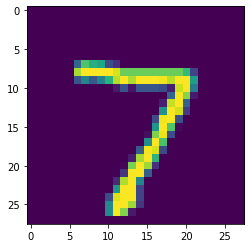

2


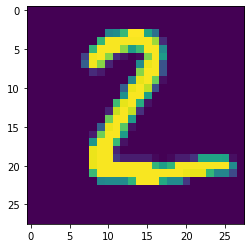

1


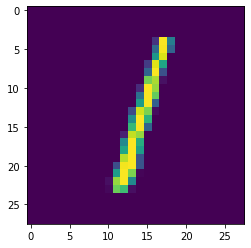

0


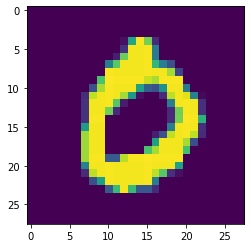

4


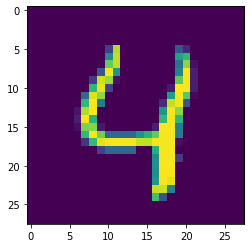

In [5]:
show5(test_loader)

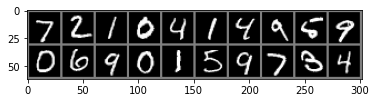

GroundTruth for first row of testloader batch_size:
      7      2      1      0      4      1      4      9      5      9


In [6]:
# Adding labels and reverting normalization step
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
inputs, labels = dataiter.next()

# Images and Labels
imshow(torchvision.utils.make_grid(inputs, nrow= 10))
print('GroundTruth for first row of testloader batch_size:\n', ' '.join('%6s' % classes[labels[j]] for j in range(10)))

In [7]:
# Further exploration of data
print(f'Size of trainingset: {len(train_loader)}\nSize of validationset: {len(valid_loader)}\n\
Size of testset: {len(testset)}\nImage shape:{trainset[0][0].shape}')

Size of trainingset: 2400
Size of validationset: 600
Size of testset: 10000
Image shape:torch.Size([1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
print(device)

cuda


In [10]:
class ModelClass(nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        
        ## Grey scale Image with 1 color channel
        # 1x28x28
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # kernel 3 and padding 1 leave dimensions unchanged in conv-layer
        # 16x14x14
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #32x7x7 
        
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
               
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #flatten Tensor
        x = x.view(-1, 32 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # return raw data for CrossEntropy() loss function
        return x

model = ModelClass()

print(model)

ModelClass(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
# Used CrossEntropyLoss which combines NLLLoss and LogSoftmax,
# so raw data is fed in to the loss function
criterion = nn.CrossEntropyLoss()

# SGD generally has a slighly better performance for training in a higher number of epochs,
# momentum is added for optimising the gradient step by weight averaging
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
# Training Pass

def train(epochs, optimizer):
    
    # track change in validation loss starting value
    valid_loss_min = np.Inf 

    # tracking for plotting
    t_loss = []
    v_loss = []
    
    for e in range(1, epochs+1):

        # loss tracking    
        train_loss = 0.0
        valid_loss = 0.0
    
        ### TRAINING PASS
    
        model.to(device)
        model.train()
        for image, label in train_loader:
            # data and model moved to device
            image = image.to(device)
            label = label.to(device)
            # zeroing gradients
            optimizer.zero_grad()
            # forward pass
            output = model(image)
            # batch loss
            loss = criterion(output, label)
            # backpropagation step
            loss.backward()
            # optimization step according to learning rate
            optimizer.step()
            # update training loss
            train_loss += loss.item()*image.size(0)
        

            ### VALIDATION PASS
        
        model.eval()
        for image, label in valid_loader:
            # data and model moved to device
            image = image.to(device)
            label = label.to(device)
            # forward pass
            output = model(image)
            # batch loss
            loss = criterion(output, label)
        
            # update average validation loss 
            valid_loss += loss.item()*image.size(0)
        
        
        # average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
    
        # tracking for plotting
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
    
        # stats 
        print(f'Epoch: {e} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
        # model checkpointing
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Checkpointing ...')
            torch.save(model.state_dict(), 'checkpoint_MNIST.pt')
            valid_loss_min = valid_loss
        
    return model, t_loss, v_loss

In [13]:
# Train for 10 epochs with learning rate 0.001, momentum 0.9, not dropout
model, t_loss, v_loss = train(10,optimizer)

Epoch: 1 	Training Loss: 0.776548 	Validation Loss: 0.040938
Validation loss decreased (inf --> 0.040938).  Checkpointing ...
Epoch: 2 	Training Loss: 0.118882 	Validation Loss: 0.021252
Validation loss decreased (0.040938 --> 0.021252).  Checkpointing ...
Epoch: 3 	Training Loss: 0.074963 	Validation Loss: 0.015899
Validation loss decreased (0.021252 --> 0.015899).  Checkpointing ...
Epoch: 4 	Training Loss: 0.055254 	Validation Loss: 0.011691
Validation loss decreased (0.015899 --> 0.011691).  Checkpointing ...
Epoch: 5 	Training Loss: 0.045906 	Validation Loss: 0.011276
Validation loss decreased (0.011691 --> 0.011276).  Checkpointing ...
Epoch: 6 	Training Loss: 0.037498 	Validation Loss: 0.014086
Epoch: 7 	Training Loss: 0.032754 	Validation Loss: 0.008874
Validation loss decreased (0.011276 --> 0.008874).  Checkpointing ...
Epoch: 8 	Training Loss: 0.028720 	Validation Loss: 0.008898
Epoch: 9 	Training Loss: 0.025163 	Validation Loss: 0.008463
Validation loss decreased (0.008874 

Plot the training loss (and validation loss/accuracy, if recorded).

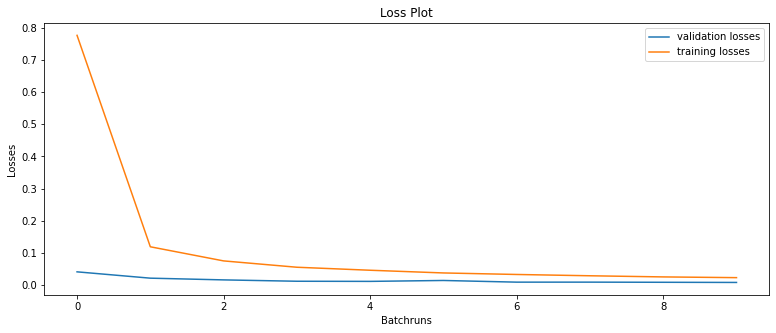

In [14]:
## Plotting Training and Validation Losses

plt.figure(figsize=(13,5))
plt.title("Loss Plot")
plt.plot(v_loss,label="validation losses")
plt.plot(t_loss,label="training losses")
plt.xlabel("Batchruns")
plt.ylabel("Losses")
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
def test():
# track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.to(device)
    model.eval()
    # forward pass on testdata
    for image, label in test_loader:
        # data and model moved to device
        image = image.to(device)
        label = label.to(device)
    
        output = model(image)
        loss = criterion(output, label)
        test_loss += loss.item()*image.size(0)
        # propabilitities to class conversion
        _, pred = torch.max(output, 1)    
        # statistical comparison
        correct_tensor = pred.eq(label.data.view_as(pred))
        # cpu only (because np.array not Tensor)
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        # accuracies
        for i in range(batch_size):
            truth = label.data[i]
            class_correct[truth] += correct[i].item()
            class_total[truth] += 1

    # test loss 
    test_loss = test_loss/len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.6f}\n')

    print(f'Accuracy for Full Testset: {100. * np.sum(class_correct)/np.sum(class_total)}%  ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

In [16]:
test()

Test Loss: 0.035322

Accuracy for Full Testset: 98.71%  (9871/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [17]:
'''
The model is already highly effective as the implementation is relatively extensive for the task at hand, for rubric satisfaction, it is experimented with hyperparamter:

- learning rate
- momentum of learning rate
- dropout
- number of epochs
'''

class ModelClass(nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        
        ## Grey scale Image with 1 color channel
        # 1x28x28
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # kernel 3 and padding 1 leave dimensions stable in conv-layer
        # 16x14x14
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #32x7x7 
        
        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # drop-out
        self.dropout = nn.Dropout(0.20)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #flatten Tensor
        x = x.view(-1, 32 * 7 * 7)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        x = self.fc3(x)
        
        # return raw data for CrossEntropy() loss function
        return x


model = ModelClass()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.7)

print("\nStart Training:")
# Train for 20 epochs with learning rate 0.0007, momentum 0.7, 20% dropout
train(20,optimizer)

print("\nTesting the Model:")
test()

ModelClass(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Start Training:
Epoch: 1 	Training Loss: 1.831073 	Validation Loss: 0.449247
Validation loss decreased (inf --> 0.449247).  Checkpointing ...
Epoch: 2 	Training Loss: 1.333839 	Validation Loss: 0.135835
Validation loss decreased (0.449247 --> 0.135835).  Checkpointing ...
Epoch: 3 	Training Loss: 0.505085 	Validation Loss: 0.067834
Validation loss decreased (0.135835 --> 0.067834).  Checkpointing ...
Epoch: 4 	Training Loss: 0.323133 	Validation Loss: 0.045968
Validation loss decreased (0.067834 --> 0.045968).  Che

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
# Best model already saved during checkpointing but for rubric valdidation model saving applied here again
torch.save(model, 'checkpoint.pth')